<a href="https://colab.research.google.com/github/harshitha2403/Hate-Speech-Detection/blob/main/Final_HSB_bert_base_uncased.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
from pathlib import Path

from collections import Counter
import random
import operator
from tqdm import tqdm
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from datasets import load_dataset
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from datasets import load_dataset
from transformers import BertModel, BertTokenizer
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
import evaluate


In [ ]:
#Loading the dataset
df = pd.read_csv('drive/My Drive/HSD3/HateSpeechDatasetBalanced.csv')
df.shape

(726119, 2)

In [ ]:
#Checking for the dupilcates if any drippong it
duplicates = df.duplicated()
print(duplicates.any())
df.isnull().any()

True


,0
text,False
label,False


In [ ]:
df = df.drop_duplicates()
print(df.shape)

(701073, 2)


In [ ]:
df.groupby('label').count()

,text
label,
0,341976
1,359097


In [ ]:
df1 = df.query('label == 0').sample(25000)
df2 = df.query('label == 1').sample(25000)
data = pd.concat([df1, df2], ignore_index=True)

data.shape

(50000, 2)

#Bert Implementsation

In [ ]:
train, test = train_test_split(data, test_size=0.25, stratify=data['label'], random_state=42)

In [ ]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [ ]:
from google.colab import files
files.download('train.csv')
files.download('test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Initiation toeknizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#Initiating model
model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
#Defining tokenizing function

def tokenized_data(data, max_length=64):
    tokenized_data = []
    for _, row in data.iterrows():
        text = row["text"]
        label = row["label"]
        encoding = tokenizer.encode_plus(text, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')
        tokenized_data.append({
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": label
        })
    return tokenized_data


In [ ]:
tokenized_train = tokenized_data(train)
tokenized_val = tokenized_data(test)

In [ ]:
#collecting function
def collate_fn(batch):
  input_ids = torch.stack([item['input_ids'] for item in batch])
  attention_mask = torch.stack([item['attention_mask'] for item in batch])
  labels = torch.tensor([item['label']
 for item in batch])

  return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
  }
batch_size = 32
dataloader_train = DataLoader(
    tokenized_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn,
    pin_memory=True,
)

dataloader_val = DataLoader(
    tokenized_val,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn,
    pin_memory=True,
)


In [ ]:
class BERT_Base(nn.Module):

    def __init__(self):

        super(BERT_Base, self).__init__()
        self.bert = model
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.linear = nn.Linear(self.bert.config.hidden_size, 1)
        self.dropout = nn.Dropout(0.1)
        for n, p in self.bert.named_parameters():
            p.requires_grad = False

    def forward(self, text, masks):
        output_bert = self.bert(text, attention_mask=masks).last_hidden_state
        output_bert = self.avg_pool(output_bert.transpose(1, 2)).squeeze(-1)

        return self.linear(self.dropout(output_bert))

In [ ]:
model = BERT_Base()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model.to(device)

val_losses = []
train_losses = []

for epoch_i in range(0, 5):

    model.train()
    print(f"Start training epoch {epoch_i}...")
    total_train_loss = 0
    for i, batch in enumerate(tqdm(dataloader_train)):

        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        masks = batch['attention_mask'].squeeze(1).to(device)
        label = batch['labels'].to(device)

        output = model(input_ids, masks)
        loss = criterion(output.squeeze(), label.float())

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(dataloader_train)
    train_losses.append(avg_train_loss)


    model.eval()
    print("Start validation...")
    y_true_bert = list()
    y_pred_bert = list()

    total_eval_loss = 0.0
    with torch.no_grad():
        for batch in dataloader_val:
            input_ids = batch['input_ids'].to(device)
            # Reshape masks to be 2D
            masks = batch['attention_mask'].squeeze(1).to(device)
            label = batch['labels'].to(device)

            output = model(input_ids, masks)
            max_output = (torch.sigmoid(output).cpu().numpy().reshape(-1)>= 0.5).astype(int)
            y_true_bert.extend(label.tolist())
            y_pred_bert.extend(max_output.tolist())

            loss_v = criterion(output.squeeze(), label.float())
            total_eval_loss += loss.item()
    avg_val_loss = total_eval_loss / len(dataloader_val)
    val_losses.append(avg_val_loss)

    print(f"Metrics after Epoch {epoch_i}")
    print(f"Accuracy : {accuracy_score(y_true_bert, y_pred_bert)}")
    print(f"Presision: {np.round(precision_score(y_true_bert, y_pred_bert),3)}")
    print(f"Recall: {np.round(recall_score(y_true_bert, y_pred_bert),3)}")
    print(f"F1: {np.round(f1_score(y_true_bert, y_pred_bert),3)}")
    print("   ")

Start training epoch 0...


  0%|          | 0/1172 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1172/1172 [02:11<00:00,  8.94it/s]

Start validation...


Metrics after Epoch 0
Accuracy : 0.76872
Presision: 0.774
Recall: 0.759
F1: 0.766
   
Start training epoch 1...


  0%|          | 0/1172 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1172/1172 [02:13<00:00,  8.81it/s]

Start validation...


Metrics after Epoch 1
Accuracy : 0.77584
Presision: 0.783
Recall: 0.763
F1: 0.773
   
Start training epoch 2...


  0%|          | 0/1172 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1172/1172 [02:13<00:00,  9.13it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1172/1172 [02:13<00:00,  8.79it/s]

Start validation...


Metrics after Epoch 2
Accuracy : 0.7832
Presision: 0.794
Recall: 0.764
F1: 0.779
   
Start training epoch 3...


  0%|          | 0/1172 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1172/1172 [02:13<00:00,  8.80it/s]

Start validation...


Metrics after Epoch 3
Accuracy : 0.77944
Presision: 0.808
Recall: 0.733
F1: 0.769
   
Start training epoch 4...


  0%|          | 0/1172 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1172/1172 [02:12<00:00,  9.02it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1172/1172 [02:13<00:00,  8.81it/s]

Start validation...


Metrics after Epoch 4
Accuracy : 0.77912
Presision: 0.804
Recall: 0.739
F1: 0.77
   


Test accuracy: 0.78

Classification report: 
               precision    recall  f1-score   support

           0       0.76      0.82      0.79      6250
           1       0.80      0.74      0.77      6250

    accuracy                           0.78     12500
   macro avg       0.78      0.78      0.78     12500
weighted avg       0.78      0.78      0.78     12500


Confusion matrix: 



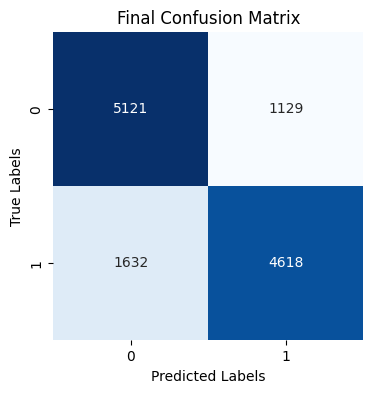

In [ ]:
print('Test accuracy: {:.2f}'.format(accuracy_score(y_true_bert, y_pred_bert)))
print('\nClassification report: \n', classification_report(y_true_bert, y_pred_bert))
print('\nConfusion matrix: \n')
cm =  confusion_matrix(y_true_bert, y_pred_bert)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Final Confusion Matrix')
plt.show()

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)
training_args = TrainingArguments(output_dir="test_trainer", report_to="none")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
metric_acc = evaluate.load("accuracy")
metric_prec = evaluate.load("precision")
metric_recall = evaluate.load("recall")
metric_f1 = evaluate.load("f1")

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = metric_acc.compute(predictions=predictions, references=labels)["accuracy"]
    prec = metric_prec.compute(predictions=predictions, references=labels)["precision"]
    rec = metric_recall.compute(predictions=predictions, references=labels)["recall"]
    f1 = metric_f1.compute(predictions=predictions, references=labels)["f1"]
    cm = confusion_matrix(labels, predictions)
    return {"accuracy": acc,"precision": prec, "recall": rec, "f1":f1, "confusion_matrix": cm.tolist()}

In [ ]:
class CustomDataCollatorWithPadding(DataCollatorWithPadding):
    def __call__(self, features):
        batch = super().__call__(features)
        # Squeeze the attention_mask tensor ERROR
        batch['attention_mask'] = batch['attention_mask'].squeeze(1)
        return batch

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
data_collator = CustomDataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
    data_collator = data_collator

)

In [ ]:
trainer.train()

Step,Training Loss
500,0.541100
1000,0.494100
1500,0.496600
2000,0.476500
2500,0.442600
3000,0.481000
3500,0.516200
4000,0.476200
4500,0.477900
5000,0.432300


TrainOutput(global_step=14064, training_loss=0.4007132324613673, metrics={'train_runtime': 1891.1599, 'train_samples_per_second': 59.487, 'train_steps_per_second': 7.437, 'total_flos': 3699999216000000.0, 'train_loss': 0.4007132324613673, 'epoch': 3.0})


Classification report: 
               precision    recall  f1-score   support

           0       0.83      0.87      0.85      6250
           1       0.86      0.83      0.84      6250

    accuracy                           0.85     12500
   macro avg       0.85      0.85      0.85     12500
weighted avg       0.85      0.85      0.85     12500



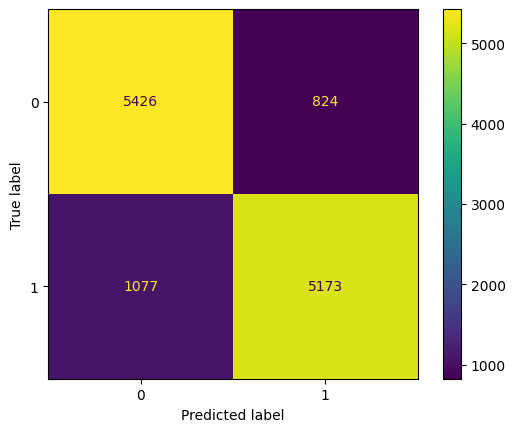

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions on the evaluation set
predictions = trainer.predict(tokenized_val)
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

print('\nClassification report: \n', classification_report(true_labels, predicted_labels))
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()